# Lab 11: Unsupervised Learning with $k$-means

In this lab, we begin our survey of common unsupervised learning methods.

## Supervised vs. Unsupervised Learning

As we know, in the supervised setting, we are presented with a set of training pairs $(\mathbf{x}^{(i)},y^{(i)}), \mathbf{x}^{(i)} \in {\cal X}, y^{(i)} \in {\cal Y},
i \in 1..m$,
where typically ${\cal X} = \mathbb{R}^n$ and either ${\cal Y} = \mathbb{R}$ (regression) or ${\cal Y} = \{ 1, \ldots, k \}$ (classification). The goal is, given a new
$\mathbf{x} \in {\cal X}$ to come up with the best possible prediction $\hat{y} \in {\cal Y}$ corresponding to $\mathbf{x}$ or a set of predicted probabilities
$p(y=y_i \mid \mathbf{x}), i \in \{1, \ldots, k\}$.

In the *unsupervised setting*, we are presented with a set of training items $\mathbf{x}^{(i)} \in {\cal X}$ without any labels or targets. The goal is generally to
understand, given a new $\mathbf{x} \in {\cal X}$, the relationship of $\mathbf{x}$ with the training examples $\mathbf{x}^{(i)}$.

The phrase *understand the relationship* can mean many different things depending on the problem setting. Among the most common specific goals is *clustering*, in which
we map the training data to $K$ *clusters*, then, given $\mathbf{x}$, find the most similar cluster $c \in \{1,\ldots,K\}$.

## $k$-means Clustering

Clustering is the most common unsupervised learning problem, and $k$-means is the most frequently used clustering algorithm. $k$-means is suitable when 
${\cal X} = \mathbb{R}^n$ and Euclidean distance is a reasonable model of dissimilarity between items in ${\cal X}$.

The algorithm is very simple:
1. Randomly initialize $k$ cluster centroids $\mu_1, \ldots, \mu_k \in \mathbb{R}^n$.
2. Repeat until convergence:
  1. For $i \in 1..m, c^{(i)} \leftarrow \text{argmin}_j \| \mathbf{x}^{(i)} - \mu_j \|^2.$
  2. For $j \in 1..k,$
     $$ \mu_j \leftarrow \frac{\sum_{i=1}^m \delta(c^{(i)} = j)\mathbf{x}^{(i)}}{\sum_{i=1}^m \delta(c^{(i)}=j)}$$

## In-Lab Exercise

Write Python code to generate 100 examples from each of three different well-separated 2D Gaussian distributions. Plot the data, initialize three arbitrary means,
and animate the process of iterative cluster assignment and cluster mean assignment. *Hint: there's a naive implementation of the algorithm in this notebook below. You can use it or make your own implementation.*

## Example with Kaggle Customer Segmentation Data

This example is based on the [Kaggle Mall Customers Dataset](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python) and [Caner Dabakoglu's](https://www.kaggle.com/cdabakoglu) tutorial on the dataset. The goal is customer segmentation.

The dataset has 5 columns, `CustomerID`, `Gender`, `Age`, `Annual Income`, and `Spending score`.
We will use three of these variables, namely `Age`, `Annual Income`, and `Spending score` for segmenting customers.
(Give some thought to why we don't use `CustomerID` or `Gender`.)

First, let's import some libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Next we read the data set and print out some information about it.

In [6]:
df = pd.read_csv("Mall_Customers.csv")

print('Dataset information:\n')
df.info()
print('\nDataset head (first five rows):\n')
df.head()

Dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Dataset head (first five rows):



,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Let's drop the `CustomerID` column, as it's not useful.

In [7]:
df.drop(["CustomerID"], axis = 1, inplace=True)

Next, let's visualize the marginal distribution over each variable, to get an idea of how cohesive they are. We can see that the variables are not
quite Gaussian and have some skew:

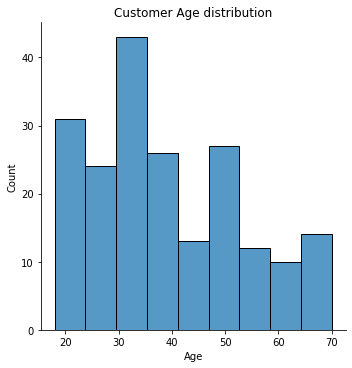

In [15]:
sns.distplot(df.Age)
_ = plt.title('Customer Age distribution')

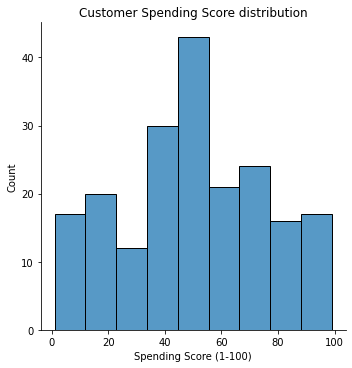

In [16]:
sns.distplot(df['Spending Score (1-100)'])
_ = plt.title('Customer Spending Score distribution')

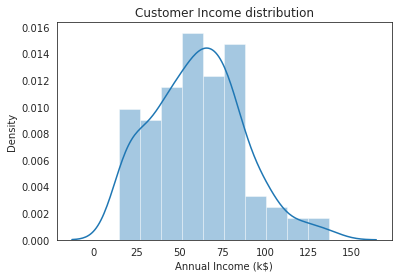

In [69]:
sns.distplot(df['Annual Income (k$)'])
_ = plt.title('Customer Income distribution')

Next, let's make a 3D scatter plot of the relevant variables:

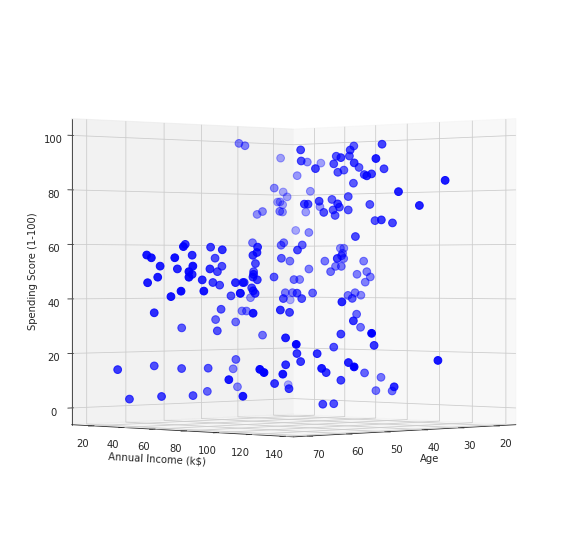

In [70]:
sns.set_style("white")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age, df["Annual Income (k$)"], df["Spending Score (1-100)"], c='blue', s=60)
ax.view_init(0, 45)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

Next, let's implement $k$-means:

In [71]:
# Initialize a k-means model given a dataset

def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

Let's build models with $k \in 1..20$, plot the distortion for each $k$, and try to choose a good value for $k$ using the so-called "elbow method."

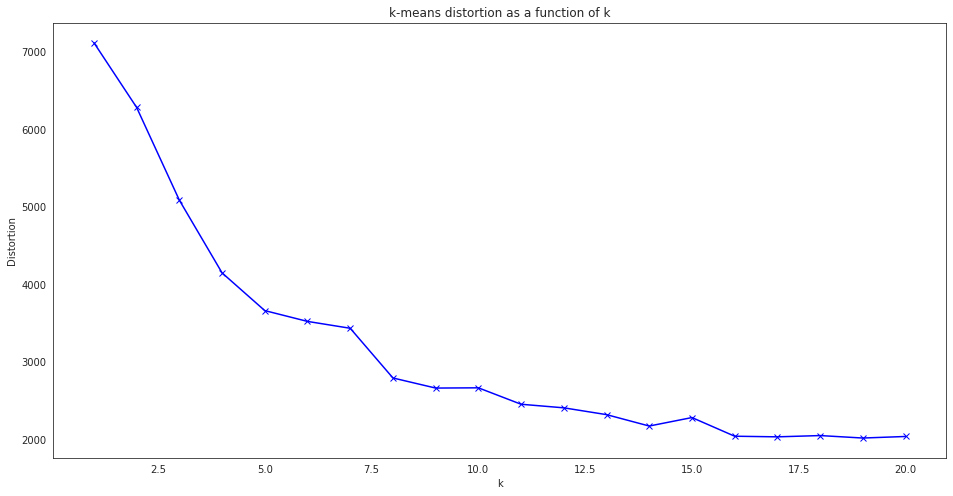

In [72]:
# Convert dataframe to matrix

X = np.array(df.iloc[:,1:])

# Intialize hyperparameters

max_k = 20
epsilon = 0.001

# For each value of k, do one run and record the resulting cost (Euclidean distortion)

distortions = np.zeros(max_k)
for k in range(1, max_k + 1):
    best_distortion = 0
    for l in range(5):
        means = init_kmeans(X, k)
        prev_distortion = 0
        while True:
            means, c, distortion = iterate_kmeans(X, means)
            if prev_distortion > 0 and prev_distortion - distortion < epsilon:
                break
            prev_distortion = distortion
        if l == 0 or distortion < distortions[k-1]:
            distortions[k-1] = distortion

# Plot distortion as function of k

plt.figure(figsize=(16,8))
plt.plot(range(1,max_k+1), distortion_k, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k-means distortion as a function of k')
plt.show()

Read about the so-called "elbow method" in [Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Note what it says,
that "In practice there may not be a sharp elbow, and as a heuristic method, such an 'elbow' cannot always be unambiguously identified." 

Do you see a unique elbow in the distortion plot above?

Note that the results are somewhat noisy, being dependent on initial conditions.

Here's a visualization of the results for three clusters:

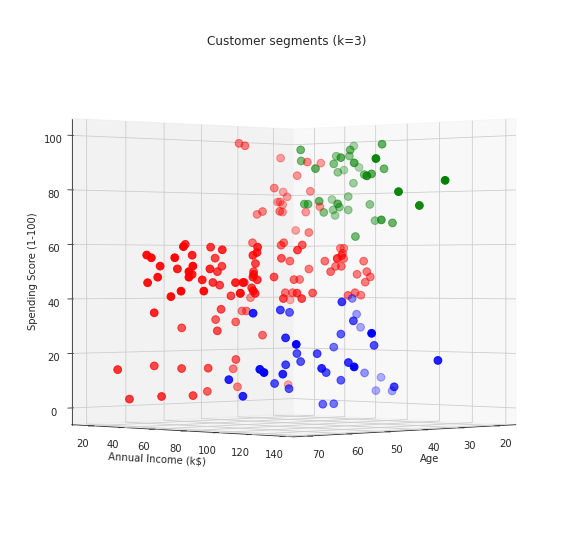

In [68]:
# Re-run k-means with k=3

k = 3
means = init_kmeans(X, k)
prev_distortion = 0
while True:
    means, c, distortion = iterate_kmeans(X, means)
    if prev_distortion > 0 and prev_distortion - distortion < epsilon:
        break
    prev_distortion = distortion
    
# Set labels in dataset to cluster IDs according to k-means model.

df["label"] = c

# Plot the data

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)

# For 5 clusters, you can uncomment the following two lines.

#ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
#ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)

ax.view_init(0, 45)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.title('Customer segments (k=3)')
plt.show()

## In-Lab Exercise 2

1. Consider the three cluster centers above. Look at the three means closely and come up with English descriptions of each cluster from a business point of view. Label the clusters in the visualization accordingly.
2. Note that the distortion plot is quite noisy due to random initial conditions. Modify the optimization to perfrom, for each $k$, several different runs, and take the minimum distortion over those runs. Re-plot the distortion plot and see if an "elbow" is more prominent.


## K-Means in PyTorch

Now, to get more experience with PyTorch, let's do the same thing with the library. First, some imports. You may need to install some packages for this to work:

    pip install kmeans-pytorch
    pip install tqdm
    
First, import the libraries:

In [63]:
import torch
from kmeans_pytorch import kmeans

In [65]:
x =  torch.from_numpy(X)
device = 'cuda:0'
device = 'cpu'
c, means = kmeans(X=x, num_clusters=3, distance='euclidean', device=torch.device(device))
df["label"] = c

[running kmeans]: 6it [00:00, 429.56it/s, center_shift=0.000000, iteration=6, tol=0.000100]  

running k-means on cpu..


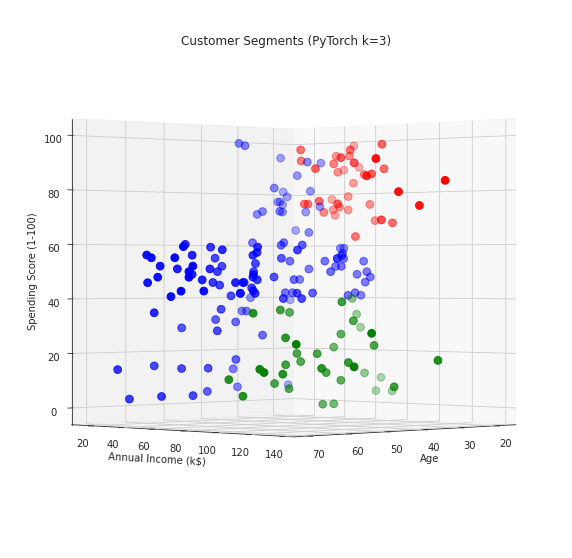

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
#ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
#ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)
ax.view_init(0, 45)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.title('Customer Segments (PyTorch k=3)')
plt.show()

## Take-Home Exercise

Find an interesting dataset for unsupervised learning, prepare the data, and run $k$-means on it.

In a brief report, describe your in-lab and take home experiments and their results.